In [61]:
from __future__ import division
from torch.backends import cudnn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import numpy as np
from matplotlib.pyplot import imshow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
# Load image file and convert it into variable
# unsqueeze for make the 4D tensor to perform conv arithmetic
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    
    if max_size is not None:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape is not None:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image.type(dtype)


In [4]:
# Pretrained VGGNet 
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract 5 conv activation maps from an input image.
        
        Args:
            x: 4D tensor of shape (1, 3, height, width).
        
        Returns:
            features: a list containing 5 conv activation maps.
        """
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [93]:
vgg

VGGNet (
  (vgg): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2d (size=(2,

In [5]:
# Image preprocessing
# For normalization, see https://github.com/pytorch/vision#models
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))])

In [27]:
max_size=400
lr=0.003
total_step=5000
log_step=10
sample_step=1000
style_weight=100

In [59]:
# Load content and style images
# make content.size() == style.size() 
content='./data/content.png'
style='./data/style.png'
import cv2
content = cv2.imread(content)
style = cv2.imread(style)

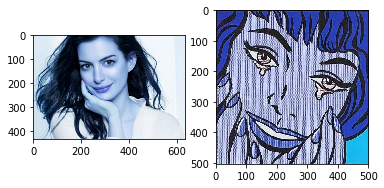

In [82]:
plt.subplot(121);plt.imshow(content)
plt.subplot(122);plt.imshow(style)
plt.show()

In [84]:
content='./data/content.png'
style='./data/style.png'
content = load_image(content, transform, max_size=max_size)
style = load_image(style, transform, shape=[content.size(2), content.size(3)])

In [85]:
disp_c=content.cpu().numpy()

In [86]:
disp_c.resize((3, 272, 400))

In [87]:
disp_c.shape

(3, 272, 400)

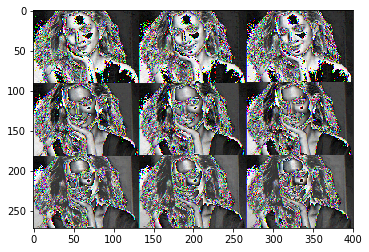

In [88]:
imshow(disp_c.reshape(( 272, 400,3)))

In [22]:
# Initialization and optimizer
target = Variable(content.clone(), requires_grad=True)
optimizer = torch.optim.Adam([target], lr=lr, betas=[0.5, 0.999])

In [23]:
vgg = VGGNet()
if use_cuda:
    vgg.cuda()

In [25]:
# Image preprocessing
# For normalization, see https://github.com/pytorch/vision#models
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))])

In [94]:
for step in range(total_step):

    # Extract multiple(5) conv feature vectors
    target_features = vgg(target)
    content_features = vgg(Variable(content))
    style_features = vgg(Variable(style))

    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # Compute content loss (target and content image)
        content_loss += torch.mean((f1 - f2)**2)

        # Reshape conv features
        _, c, h, w = f1.size()
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)

        # Compute gram matrix  
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())

        # Compute style loss (target and style image)
        style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 

    # Compute total loss, backprop and optimize
    loss = content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % log_step == 0:
        print ('Step [%d/%d], Content Loss: %.4f, Style Loss: %.4f' 
               %(step+1, total_step, content_loss.data[0], style_loss.data[0]))

    if (step+1) % sample_step == 0:
        # Save the generated image
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = target.clone().cpu().squeeze()
        img = denorm(img.data).clamp_(0, 1)
        torchvision.utils.save_image(img, 'output-%d.png' %(step+1))

Step [10/5000], Content Loss: 5.1528, Style Loss: 24391.9707
Step [20/5000], Content Loss: 12.9249, Style Loss: 22110.9395
Step [30/5000], Content Loss: 20.2621, Style Loss: 19643.4453
Step [40/5000], Content Loss: 26.9291, Style Loss: 17231.5840
Step [50/5000], Content Loss: 33.0742, Style Loss: 14975.2998
Step [60/5000], Content Loss: 38.6706, Style Loss: 12901.8301
Step [70/5000], Content Loss: 43.8043, Style Loss: 11017.6064
Step [80/5000], Content Loss: 48.5434, Style Loss: 9336.4619
Step [90/5000], Content Loss: 52.8803, Style Loss: 7869.3525
Step [100/5000], Content Loss: 56.8348, Style Loss: 6620.5225
Step [110/5000], Content Loss: 60.3709, Style Loss: 5578.7607
Step [120/5000], Content Loss: 63.5002, Style Loss: 4721.7783
Step [130/5000], Content Loss: 66.2382, Style Loss: 4022.3796
Step [140/5000], Content Loss: 68.6338, Style Loss: 3449.1558
Step [150/5000], Content Loss: 70.6919, Style Loss: 2980.1243
Step [160/5000], Content Loss: 72.4538, Style Loss: 2595.3865
Step [170/5

Step [1350/5000], Content Loss: 96.5077, Style Loss: 173.9043
Step [1360/5000], Content Loss: 96.5534, Style Loss: 172.4785
Step [1370/5000], Content Loss: 96.5997, Style Loss: 171.0670
Step [1380/5000], Content Loss: 96.6441, Style Loss: 169.6745
Step [1390/5000], Content Loss: 96.6882, Style Loss: 168.3014
Step [1400/5000], Content Loss: 96.7323, Style Loss: 166.9483
Step [1410/5000], Content Loss: 96.7758, Style Loss: 165.6136
Step [1420/5000], Content Loss: 96.8180, Style Loss: 164.2970
Step [1430/5000], Content Loss: 96.8587, Style Loss: 162.9962
Step [1440/5000], Content Loss: 96.8999, Style Loss: 161.7140
Step [1450/5000], Content Loss: 96.9412, Style Loss: 160.4490
Step [1460/5000], Content Loss: 96.9823, Style Loss: 159.2011
Step [1470/5000], Content Loss: 97.0244, Style Loss: 157.9701
Step [1480/5000], Content Loss: 97.0652, Style Loss: 156.7536
Step [1490/5000], Content Loss: 97.1045, Style Loss: 155.5511
Step [1500/5000], Content Loss: 97.1433, Style Loss: 154.3676
Step [15

Step [2680/5000], Content Loss: 100.5574, Style Loss: 75.2907
Step [2690/5000], Content Loss: 100.5795, Style Loss: 74.9197
Step [2700/5000], Content Loss: 100.6013, Style Loss: 74.5517
Step [2710/5000], Content Loss: 100.6239, Style Loss: 74.1852
Step [2720/5000], Content Loss: 100.6463, Style Loss: 73.8218
Step [2730/5000], Content Loss: 100.6693, Style Loss: 73.4611
Step [2740/5000], Content Loss: 100.6917, Style Loss: 73.1033
Step [2750/5000], Content Loss: 100.7158, Style Loss: 72.7480
Step [2760/5000], Content Loss: 100.7388, Style Loss: 72.3951
Step [2770/5000], Content Loss: 100.7620, Style Loss: 72.0445
Step [2780/5000], Content Loss: 100.7843, Style Loss: 71.6968
Step [2790/5000], Content Loss: 100.8064, Style Loss: 71.3528
Step [2800/5000], Content Loss: 100.8297, Style Loss: 71.0118
Step [2810/5000], Content Loss: 100.8523, Style Loss: 70.6743
Step [2820/5000], Content Loss: 100.8751, Style Loss: 70.3390
Step [2830/5000], Content Loss: 100.8974, Style Loss: 70.0068
Step [28

Step [4010/5000], Content Loss: 103.2260, Style Loss: 42.9474
Step [4020/5000], Content Loss: 103.2435, Style Loss: 42.7875
Step [4030/5000], Content Loss: 103.2610, Style Loss: 42.6289
Step [4040/5000], Content Loss: 103.2780, Style Loss: 42.4714
Step [4050/5000], Content Loss: 103.2949, Style Loss: 42.3147
Step [4060/5000], Content Loss: 103.3111, Style Loss: 42.1592
Step [4070/5000], Content Loss: 103.3281, Style Loss: 42.0043
Step [4080/5000], Content Loss: 103.3451, Style Loss: 41.8507
Step [4090/5000], Content Loss: 103.3631, Style Loss: 41.6976
Step [4100/5000], Content Loss: 103.3811, Style Loss: 41.5456
Step [4110/5000], Content Loss: 103.3999, Style Loss: 41.3942
Step [4120/5000], Content Loss: 103.4175, Style Loss: 41.2431
Step [4130/5000], Content Loss: 103.4350, Style Loss: 41.0926
Step [4140/5000], Content Loss: 103.4517, Style Loss: 40.9431
Step [4150/5000], Content Loss: 103.4687, Style Loss: 40.7942
Step [4160/5000], Content Loss: 103.4855, Style Loss: 40.6460
Step [41

In [99]:
results=[]
for step in range(999,5001,1000):
    img=plt.imread('output-%d.png' %(step+1))
    img=np.array(img)
    results.append(img)

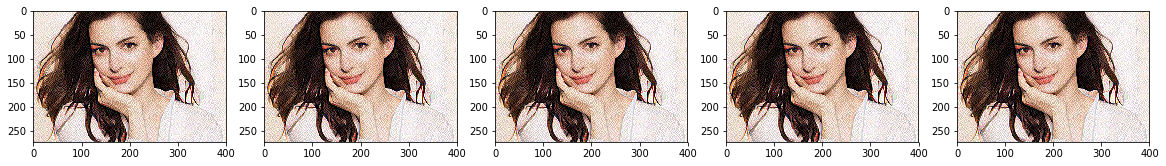

In [114]:
fig = plt.figure(figsize=(20,20)) 
for i in range(1,6):
   plt.subplot("15%d"%i);plt.imshow(results[0])